<a href="https://colab.research.google.com/github/tengfeixia/RN_avec_des_incertitudes_propag-es/blob/main/DNN_version2_1_adam(test_dim%3E2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

print ("TF Version", tf.__version__)

TF Version 2.5.0


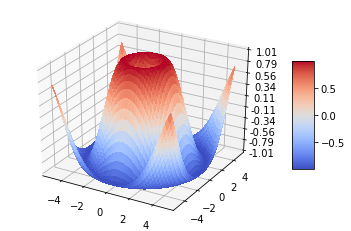

In [2]:
# generate data

X= np.arange (-5,5,0.001)
Y= np.arange (-5,5,0.001)
X,Y = np.meshgrid (X,Y)
R = np.sqrt (X**2 + Y**2)
Z = np.sin (R)

fig = plt.figure()
ax=fig.gca(projection = '3d')
surf = ax.plot_surface (X,Y,Z, cmap = cm.coolwarm, linewidth=0, antialiased = False)

ax.set_zlim(-1.01,1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

x
 [[-5.   ]
 [-4.999]
 [-4.998]
 ...
 [ 4.997]
 [ 4.998]
 [ 4.999]]
y
 [[-5.   ]
 [-4.999]
 [-4.998]
 ...
 [ 4.997]
 [ 4.998]
 [ 4.999]]
X_train
 [[-5.    -5.   ]
 [-4.999 -4.999]
 [-4.998 -4.998]
 ...
 [ 4.997  4.997]
 [ 4.998  4.998]
 [ 4.999  4.999]]
z
 [[0.70886129]
 [0.70786307]
 [0.70686343]
 ...
 [0.70586238]
 [0.70686343]
 [0.70786307]]


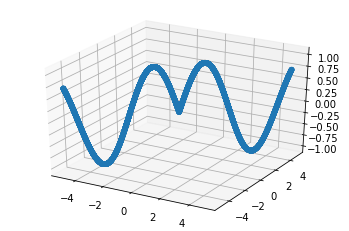

In [3]:
x = np.arange(-5,5,0.001)
x = np.atleast_2d(x)
x = x.T
print ("x\n",x)

y= np.arange(-5,5,0.001)
y= np.atleast_2d(y)
y=y.T
print ("y\n",y)

r= np.sqrt(x**2+y**2)
z = np.sin (r)


my_train = np.hstack((x,y))

print ("X_train\n", my_train)
print ("z\n",z)
my_test = z

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter3D(x,y,z)


In [13]:
class Layer:

    def __init__ (self,n_input,n_neurons, activation = None, weights = None, bias = None):

        """
        int n_input: nb de noeuds entrées (nb de noeuds de la couche précédente)
        int n_neurons: nb de noeuds sorties (nb de noeuds de la couche actuelle)
        str activation: type de la fonction d'activation 
        weights, bias: généré dans les couches
        """

        self.weights = weights if weights is not None else np.random.randn(n_input,n_neurons)*np.sqrt(2/(n_neurons+n_input))  
        self.bias = bias if bias is not None else np.zeros((n_neurons))

                        
        self.nb_neurons = n_neurons 

        self.activation = activation
        self.activation_value = None
        self.error = None
        self.delta = None
        self.gradient = None
        self.x = None
        self.z = None

        #pour adam
        #bias
        self.v_b = 0
        self.grad_sq_b = 0
        self.v_hat_b = 0
        self.grad_sq_hat_b = 0

        #weights
        self.v_w = 0
        self.grad_sq_w = 0
        self.v_hat_w = 0
        self.grad_sq_hat_w = 0
        self.grad = None 

        # feed forward propagation

    def feedforward (self,x):
        self.x = x
        z = np.dot (x,self.weights) + self.bias # z = wx+b
        self.z =z
        self.activation_value = self.apply_activation (z)
        return self.activation_value

        # fonction d'activaiton

    def apply_activation(self, z):

        if self.activation is None:
            return z
        elif self.activation == "relu":
            return np.maximum(z, 0)
        elif self.activation == "tanh":
            return np.tanh(z)
        elif self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z))
    

        # dérivés des fonctions d'activation,， attention le input c'est a, value activé
    def apply_activation_derivation(self, a):

        if self.activation is None:
            return np.ones_like(a)
        elif self.activation == "relu":
            grad = np.array(a, copy=True)
            grad[a > 0] = 1.
            grad[a<= 0] = 0.
            return grad
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "sigmoid":
            return a* (1 - a)



MSE: 0.2036726773905021
MSE: 0.0019544554346961063
MSE: 0.016916894276863922
MSE: 0.00399658788486268
MSE: 0.003366319898512749
MSE: 0.0013226973730183773
MSE: 0.007507519090490797
MSE: 0.0075705915984997695
MSE: 0.0062360967041063245
MSE: 0.00579376621336128


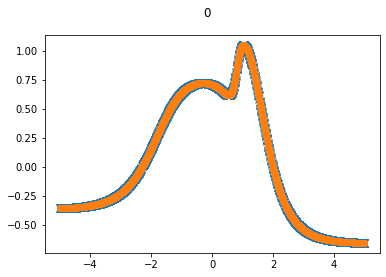

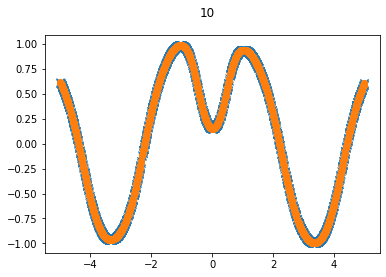

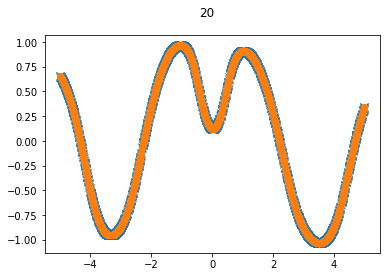

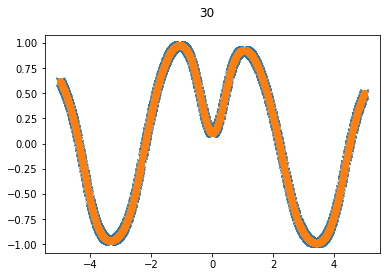

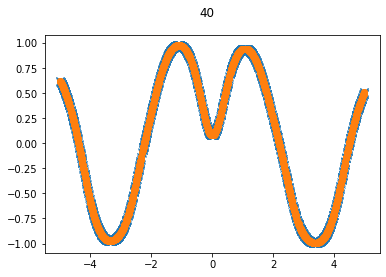

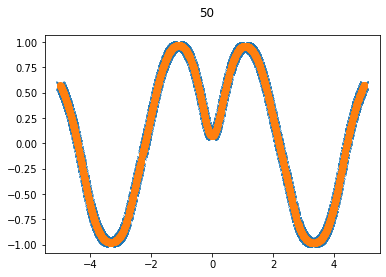

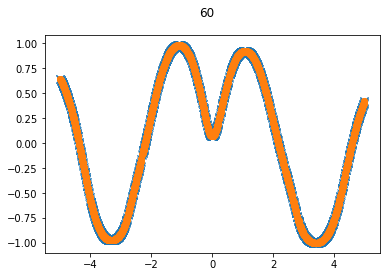

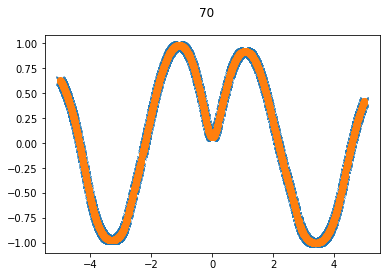

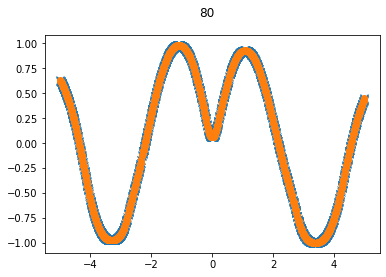

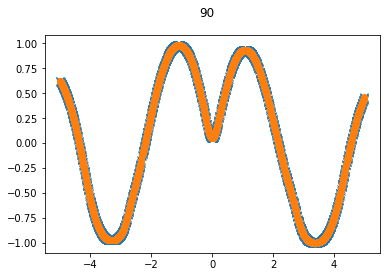

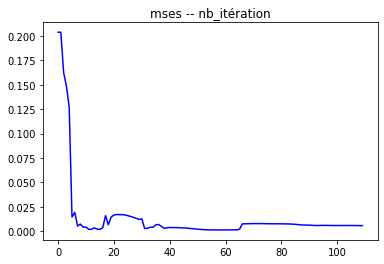

In [14]:
# Neural Network

class NN:
    def __init__ (self):
        self.__layers = []
        
        #paramètres adam
        self.gamma = 0.9
        self.beta = 0.99
        self.epsilon = 10**-8
        

    def add_layer (self, layer): #add layer
        self.__layers.append(layer)

    def feed_forward (self, X): # X --> my_nn.feed_forward (X) --> y_predict
        for layer in self.__layers:
            X = layer.feedforward (X)
        return X

    def back_propagation (self, X_train, y_train, lr):
        y_predict = self.feed_forward(X_train)

    

        for i in reversed(range(len(self.__layers))):
            current_layer = self.__layers[i] #get layer            
    
            if current_layer == self.__layers [-1]:  # si current == couche output
                current_layer.error = y_predict - y_train 
                current_layer.delta = 2*current_layer.error * current_layer.apply_activation_derivation (y_predict) 
                previous_layer = self.__layers [i-1]

                #adam pour bias            
                current_layer.v_b = self.gamma*current_layer.v_b + (1-self.gamma)*current_layer.delta
                current_layer.grad_sq_b = self.beta*current_layer.grad_sq_b + (1- self.beta)*np.square (current_layer.delta)
                current_layer.v_hat_b = current_layer.v_b / (1- self.gamma)
                current_layer.grad_sq_hat_b = current_layer.grad_sq_b / (1- self.beta)
                #print ("test1",current_layer.bias)
                current_layer.bias -= lr * np.divide (current_layer.v_hat_b, np.sqrt (current_layer.grad_sq_hat_b+ self.epsilon) )

                #print ("test2",current_layer.bias)
                
                
                #adam pour weights
                
                current_layer.grad = current_layer.delta*(np.atleast_2d(previous_layer.activation_value)).T
                current_layer.v_w = self.gamma*current_layer.v_w + (1-self.gamma)*current_layer.grad
                current_layer.grad_sq_w= self.beta*current_layer.grad_sq_w + (1-self.beta)*np.square(current_layer.grad)
                current_layer.v_hat_w = current_layer.v_w / (1- self.gamma)
                current_layer.grad_sq_hat_w = current_layer.grad_sq_w/ (1- self.gamma)
                current_layer.weights -= lr*np.divide(current_layer.v_hat_w,np.sqrt(current_layer.grad_sq_hat_w+self.epsilon))
                

            
            else:
                next_layer = self.__layers[i+1] #les incertitudes dépendent de la couche prochaine
                
                current_layer.error = np.dot(next_layer.weights, next_layer.delta)
             
                current_layer.delta = current_layer.error* current_layer.apply_activation_derivation(current_layer.activation_value)

                
                # ________________________________adam pour bias
                current_layer.v_b = self.gamma*current_layer.v_b + (1-self.gamma)*current_layer.delta
                current_layer.grad_sq_b = self.beta*current_layer.grad_sq_b + (1- self.beta)*np.square (current_layer.delta)
                current_layer.v_hat_b = current_layer.v_b / (1- self.gamma)
                current_layer.grad_sq_hat_b = current_layer.grad_sq_b / (1- self.beta)
                
                current_layer.bias -= lr * np.divide (current_layer.v_hat_b, np.sqrt (current_layer.grad_sq_hat_b+ self.epsilon) )

                #__________________________________adam pour weights

                
                previous_layer = self.__layers [i-1]
    
                current_layer.grad = current_layer.delta*(np.atleast_2d(previous_layer.activation_value if current_layer != self.__layers [0] else X_train )).T
                current_layer.v_w = self.gamma*current_layer.v_w + (1-self.gamma)*current_layer.grad
                current_layer.grad_sq_w= self.beta*current_layer.grad_sq_w + (1-self.beta)*np.square(current_layer.grad)
                current_layer.v_hat_w = current_layer.v_w / (1- self.gamma)
                current_layer.grad_sq_hat_w = current_layer.grad_sq_w/ (1- self.gamma)
                current_layer.weights -= lr*np.divide(current_layer.v_hat_w,np.sqrt(current_layer.grad_sq_hat_w+self.epsilon))



    def train (self,X_train,X_test,y_train, y_test, lr, epochs):
        mses = []
        for i in range (epochs):
            for j in range (len (X_train)):

                self.back_propagation(X_train[j],y_train[j],lr)

            
            mse = np.mean(np.square(self.feed_forward(X_train)- y_train))
            mses.append(mse)
            if i % 10 ==0:
                    
                
                print ("MSE:", mse)
                mses.append(mse)

                plt.figure()
                plt.suptitle(i)
                plt.plot (X_test[:,0],self.feed_forward(X_test), "x", markersize = 8)
                plt.plot (X_test[:,1],self.feed_forward(X_test), "o", markersize = 6)



        return mses



    


my_nn = NN()
my_nn.add_layer(Layer(2, 4, "tanh"))  # 1 --> 4
my_nn.add_layer(Layer(4, 4, "tanh"))  # 1 --> 4
my_nn.add_layer(Layer(4, 2, "tanh"))
my_nn.add_layer(Layer(2, 1, None))  # 4 --> 2


X_train, X_test, y_train, y_test = train_test_split (my_train,my_test,test_size = 0.25, shuffle = True)


mses = my_nn.train(X_train ,X_test,y_train,y_test,0.001,100)

plt.figure()
plt.title("mses -- nb_itération")

plt.plot(mses, 'b', label='MSE Loss')
